# Read time-dependent FISH transcriptome data from Aouefa

#### Read Excel sheet:

In [1]:
import pandas as pd
import csv
import cPickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import collections

%matplotlib inline

from pygenome import sg

In [2]:
phase_lengths = collections.OrderedDict([('early G1', 27.2), ('late G1', 33.7), ('S', 20.5), ('G2', 21.4), ('P/M', 9.8), 
                                         ('Ana', 10.4), ('T/C', 4.1)])
sum(phase_lengths.values())

127.10000000000001

In [3]:
phase_lengths.values()

[27.2, 33.7, 20.5, 21.4, 9.8, 10.4, 4.1]

Note that these are ordered as in the `OrderedDict`.

Aouefa's pivot table file containing distributions from the FISH experiments:

In [4]:
mrna_file = '../data/Sup_PivotTable_RNA_forPubli_AllGenes.xlsx'

In [5]:
df = {}
df_mult = {}
df_means = {}

In the following we make sure to only read the first table as the ones underneath contain data from osmostressed experiments.

In [6]:
df['SIC1'] = pd.read_excel(mrna_file, sheetname='SIC1', skiprows=1, skipfooter=251, parse_cols='A, C:I')
df['SIC1'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,22,24,22,24,6,1,0
1,1,35,53,41,45,22,1,0
2,2,48,74,54,36,20,10,0
3,3,30,52,22,19,10,6,0
4,4,10,19,9,10,6,4,0


In [7]:
df['CLN2'] = pd.read_excel(mrna_file, sheetname='CLN2', skiprows=1, skipfooter=260, parse_cols='A, C:I')
df['CLN2'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,123,15,38,105,55,35,11
1,1,27,8,22,37,12,23,6
2,2,11,11,9,20,6,3,3
3,3,12,7,12,4,1,2,1
4,4,10,2,2,1,0,2,0


In [8]:
df['CLB5'] = pd.read_excel(mrna_file, sheetname='CLB5', skiprows=1, skipfooter=89, parse_cols='A, C:I')
df['CLB5'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,69,35,55,94,43,45,6
1,1,46,47,47,31,19,26,10
2,2,27,27,27,12,8,5,1
3,3,10,25,22,5,0,3,2
4,4,4,32,12,3,0,4,3


#### Calculate means per cell cycle phase:

In [9]:
df_mult['SIC1'] = df['SIC1'].mul(df['SIC1']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['SIC1'] = df_mult['SIC1'].sum(axis=0) / df['SIC1'].sum(axis=0).drop('# RNA/cell')
df_means['SIC1']

early G1     4.084577
late G1      3.449275
S            2.343195
G2           2.055944
P/M          2.101449
Ana         14.231884
T/C         24.933333
dtype: float64

In [10]:
df_mult['CLN2'] = df['CLN2'].mul(df['CLN2']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['CLN2'] = df_mult['CLN2'].sum(axis=0) / df['CLN2'].sum(axis=0).drop('# RNA/cell')
df_means['CLN2']

early G1     3.254237
late G1     18.021277
S            5.644628
G2           0.666667
P/M          0.364865
Ana          1.119403
T/C          2.592593
dtype: float64

In [11]:
df_mult['CLB5'] = df['CLB5'].mul(df['CLB5']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['CLB5'] = df_mult['CLB5'].sum(axis=0) / df['CLB5'].sum(axis=0).drop('# RNA/cell')
df_means['CLB5']

early G1    1.321429
late G1     3.783784
S           1.826816
G2          0.565517
P/M         0.619718
Ana         0.977273
T/C         2.793103
dtype: float64

We know have absolute abundance values of three transcript types during the whole cell cycle. The next step will be to combine this information with the relative abundance data from Lotte's RNAseq experiments.

#### Discover corresponding genes in Lotte transcriptome:

YLR079W is Sic1

YPL256C is Cln2

YPR120C is Clb5

Read file:

In [12]:
filename = "../data/nostress_WT_R1.csv"
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))

transcripts = pd.DataFrame()

with open(filename, mode='r') as infile:
    reader = csv.reader(infile, delimiter=',')
    times = [int(float(val)) for val in reader.next()[1:]]
    ntimes = len(times)
    for rows in reader:
        try:
            # convert to systematic names
            colname = rows[0] if rows[0] in orf_genomic_dict else sg.systematic_name(rows[0])
            transcript_values = pd.Series(data=[float(rows[i]) for i in range(2, ntimes + 1)])  # the time point -1 is not needed
            transcripts[colname] = transcript_values
        except:
            pass

In [13]:
transcripts.index = times[1:]
print len(transcripts.columns)

5795


Create "normalized" transcriptome (containing percentages at each point in time):

In [14]:
transcripts_norm = (transcripts.T / transcripts.sum(axis=1)).T

Plot cell cycle genes in Lotte data:

In [15]:
sic1 = transcripts_norm['YLR079W']
cln2 = transcripts_norm['YPL256C']
clb5 = transcripts_norm['YPR120C']

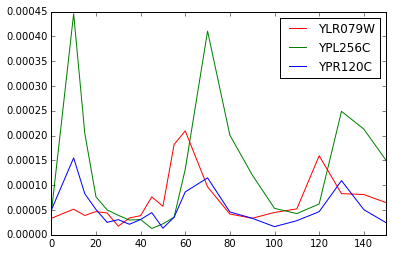

In [16]:
sic1.plot(legend=True, color='r')
cln2.plot(legend=True, color='g')
clb5.plot(legend=True, color='b')

According to Lotte, the  G1 phase of the first cell cycle is missing because cells are released from the G1 phase.

According to Max/Marcus, the  G1 phase of the second cell cycle is also shortened because cells were kept in arrest and were allowed to build capacity to shorten the G1 phase.

Plot Aouefa's data for comparison:

In [17]:
df_means['SIC1'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.
df_means['CLN2'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.
df_means['CLB5'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.

In [18]:
means = pd.DataFrame(df_means)

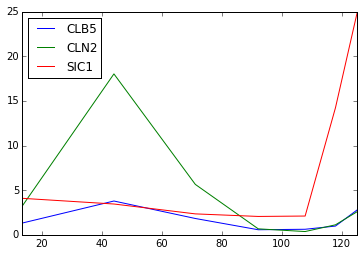

In [19]:
means.plot()

The data look qualitatively similar but with a longer G1 phase.

Next steps: 

* assume that the very first data point of RNAseq data represents the G1 phase
* find boundaries of other phases
* calculate averages of RNAseq data per cell cycle phase
* calculate multipliers per cell cycle phase for each cell cycle gene
* find "best" multiplier (e.g. average of the three multipliers)
* use multipliers to calculate absolute transcriptome

#### Find total length of RNAseq cell cycle:

In [20]:
cln2.sort_values(axis=0, ascending=False, inplace=False)[:3]

10     0.000446
70     0.000411
130    0.000249
Name: YPL256C, dtype: float64

We see that the sum of all phases except the absent G1 phase is 60 mins.

Corresponding duration in Aouefa's data:

In [21]:
sum(phase_lengths.values()[2:])

66.2

To match the cell cycle we will scale Aouefa's values down by 66.2/60.0 (except the G1 lengths):

In [39]:
rnaseq_phase_lengths = collections.OrderedDict([('early G1', round(27.2 * 60.0/66.2, 1)), 
                                                ('late G1', round(33.7 * 60.0/66.2, 1)), 
                                                ('S', round(20.5 * 60.0/66.2, 1)), 
                                                ('G2', round(21.4 * 60.0/66.2, 1)), ('P/M', round(9.8 * 60.0/66.2, 1)), 
                                                ('Ana', round(10.4 * 60.0/66.2, 1)), ('T/C', round(4.1 * 60.0/66.2,1))])

In [40]:
rnaseq_phase_lengths

OrderedDict([('early G1', 24.7), ('late G1', 30.5), ('S', 18.6), ('G2', 19.4), ('P/M', 8.9), ('Ana', 9.4), ('T/C', 3.7)])

In [50]:
round(sum(rnaseq_phase_lengths.values()), 1)

115.2

Next we calculate the averages of the cell cycle genes in RNAseq per cell cycle phase. 

* The first measurement is used as a proxy for the entire G1 phase.
* Only the first cell cycle is considered.
* To be able to map the times accurately, we first "blow up" the RNAseq data in units of 0.1 min

In [42]:
rnaseq_means = {}
rnaseq_means['SIC1'] = {'early G1': sic1[0], 'late G1': sic1[0]}

In [43]:
rnaseq_means

{'SIC1': {'early G1': 3.3234762501156854e-05,
  'late G1': 3.3234762501156854e-05}}

The other values are defined in the following.

TODO: The index should begin at the beginning of S phase (24.7 + 30.5 + 0.1) and end after T/C phase (115.2)

In [60]:
detail_df = pd.DataFrame(np.arange(0, round(sum(rnaseq_phase_lengths.values()), 1), 0.1))

In [61]:
detail_df = detail_df.set_index(np.arange(0, round(sum(rnaseq_phase_lengths.values()), 1), 0.1))

In [62]:
detail_sic1_df = detail_df.join(sic1)

In [65]:
detail_sic1_df.drop(0, axis=1, inplace=True)

In [66]:
detail_sic1_df[detail_sic1_df['YLR079W']>0]

,YLR079W
0,0.000033
10,0.000052
15,0.000039
20,0.000047
25,0.000044
30,0.000017
35,0.000034
40,0.000039
45,0.000077
50,0.000057


In [41]:
#detail_sic1_df.interpolate(method='polynomial', order=2, axis=0)
detail_sic1_df = detail_sic1_df.interpolate(method='index', axis=0)

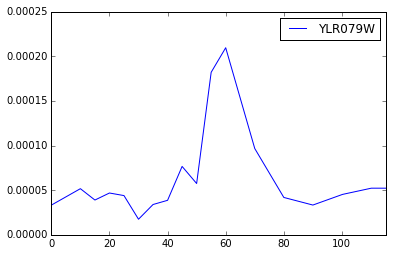

In [42]:
detail_sic1_df.plot()